In [21]:
import numpy as np
import xarray as xr

In [62]:
folder = "/home/amir/Projects/Python/Atmpy/atmpy/output_data/traveling_vortex/archive/"
suffix = "/_traveling_vortex_"
sizes = ["16_16.nc", "32_32.nc", "64_64.nc", "128_128.nc", "256_256.nc"]
axis = [8,]

In [63]:
data_var = "p2_nodes"
l2_values = []
l_inf_values = []
for size in sizes:
    path = folder + suffix + size
    ds = xr.open_dataset(path)
    initial = ds[data_var].isel(time=0).data
    final = ds[data_var].isel(time=-1).data
    diff = initial - final
    l2 = np.sqrt(np.mean(diff**2))
    l_inf = np.max(np.abs(diff))
    l2_values.append(l2)
    l_inf_values.append(l_inf)

/tmp/ipykernel_9636/3500019398.py:6: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset(path)
/tmp/ipykernel_9636/3500019398.py:6: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset(path)
/tmp/ipykernel_9636/3500019398.py:6: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset(path)
/tmp/ipykernel_9636/3500019398.py:6: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'C

In [64]:
l2_values

[0.00389509060788645,
 0.003354972462046142,
 0.003018451381421565,
 0.0028976943007676293,
 0.0029094522788563775]

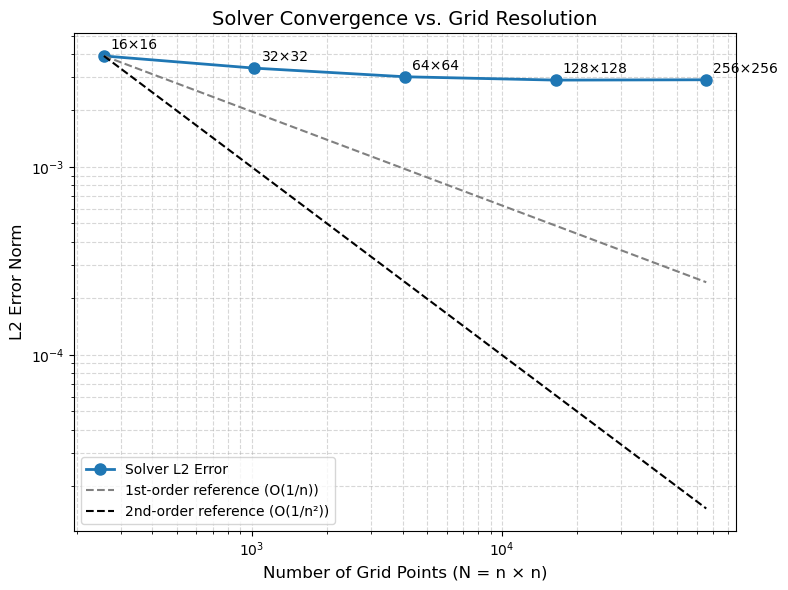

In [65]:
import matplotlib.pyplot as plt

# Your data (replace with actual values)
n_values = np.array([16, 32, 64, 128, 256])  # Grid points along one dimension (n x n grids)
l2_errors = l2_values  # Example L2 errors

# Compute total grid points (N = n × n)
N_values = n_values ** 2

# Reference lines (scaled to match the first data point)
ref_N1 = (1 / n_values) * (l2_errors[0] / (1 / n_values[0]))  # 1st-order (O(1/n))
ref_N2 = (1 / n_values**2) * (l2_errors[0] / (1 / n_values[0]**2))  # 2nd-order (O(1/n²))

# Plot
plt.figure(figsize=(8, 6))
plt.loglog(N_values, l2_values, 'o-', label='Solver L2 Error', markersize=8, linewidth=2)
plt.loglog(N_values, ref_N1, '--', label='1st-order reference (O(1/n))', color='gray')
plt.loglog(N_values, ref_N2, '--', label='2nd-order reference (O(1/n²))', color='black')

# Labels and title
plt.xlabel('Number of Grid Points (N = n × n)', fontsize=12)
plt.ylabel('L2 Error Norm', fontsize=12)
plt.title('Solver Convergence vs. Grid Resolution', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, which="both", ls="--", alpha=0.5)

# Annotate grid sizes (e.g., "8×8", "16×16", etc.)
for i, n in enumerate(n_values):
    plt.annotate(f"{n}×{n}", (N_values[i], l2_errors[i]),
                 textcoords="offset points", xytext=(5,5), ha='left')

plt.tight_layout()
plt.show()


In [42]:
import scipy as sp

def project_fine_to_coarse_2d_average(fine_grid_data, r_factor):
    """
    Projects cell-centered data from a fine grid to a coarse grid by averaging.
    Assumes fine_grid_data is 2D (Ny_fine, Nx_fine).
    r_factor is the refinement ratio (e.g., 2).
    """
    Ny_fine, Nx_fine = fine_grid_data.shape
    Ny_coarse, Nx_coarse = Ny_fine // r_factor, Nx_fine // r_factor
    coarse_grid_data = np.zeros((Ny_coarse, Nx_coarse))

    for j_coarse in range(Ny_coarse):
        for i_coarse in range(Nx_coarse):
            # Get the block of fine cells corresponding to this coarse cell
            j_start_fine, j_end_fine = j_coarse * r_factor, (j_coarse + 1) * r_factor
            i_start_fine, i_end_fine = i_coarse * r_factor, (i_coarse + 1) * r_factor
            fine_cell_block = fine_grid_data[j_start_fine:j_end_fine, i_start_fine:i_end_fine]
            coarse_grid_data[j_coarse, i_coarse] = np.mean(fine_cell_block)
    return coarse_grid_data

# Example usage:
# U1 (16x16), U2 (32x32), U3 (64x64) are your solution arrays
# r = 2

sizes = ["8_8.nc", "16_16.nc", "32_32.nc", "64_64.nc", "128_128.nc"] # Grid points along one dimension (n x n grids)
test_sizes = [32, 64]
size = "64_64.nc"

data_var = "rho"

path = folder + suffix + size
ds = xr.open_dataset(path)
sol_64 = ds[data_var].isel(time=-1).data

size = "32_32.nc"
path = folder + suffix + size
ds = xr.open_dataset(path)
sol_32 = ds[data_var].isel(time=-1).data

size = "16_16.nc"
path = folder + suffix + size
ds = xr.open_dataset(path)
sol_16 = ds[data_var].isel(time=-1).data

kernel = [[1, 1, 1], [1, 1, 1], [1, 1, 1]]
u = sp.signal.fftconvolve(sol_64, kernel, mode='valid')
print(u.shape)

# Compare U1 and U2
# sol_64_on_32 = project_fine_to_coarse_2d_average(sol_64, 2) # U2 (32x32) -> (16x16)
# # Now U1 and U2_on_grid1 have the same shape (16x16)
# diff_21_field = sol_32 - sol_64_on_32
# norm_diff_21 = np.linalg.norm(diff_21_field) # L2 norm
#
# # Compare U2 and U3
# sol_32_on_16 = project_fine_to_coarse_2d_average(sol_32, 2) # U3 (64x64) -> (32x32)
# # Now U2 and U3_on_grid2 have the same shape (32x32)
# diff_32_field = sol_16 - sol_32_on_16
# norm_diff_32 = np.linalg.norm(diff_32_field)
#
# print(norm_diff_32, norm_diff_21)

/tmp/ipykernel_9636/3156969329.py:33: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset(path)
/tmp/ipykernel_9636/3156969329.py:38: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset(path)
/tmp/ipykernel_9636/3156969329.py:43: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset(path)


(62, 62)
